Importing Libraries

In [25]:
import astropy
import photutils
from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm
from astropy.table import QTable
import os

import numpy as np
import os
import matplotlib.pyplot as plt

from photutils.background import LocalBackground, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.psf import IterativePSFPhotometry, IntegratedGaussianPRF

Loading Files

m29_2023-09-20_20-30-17_black_0159.fits


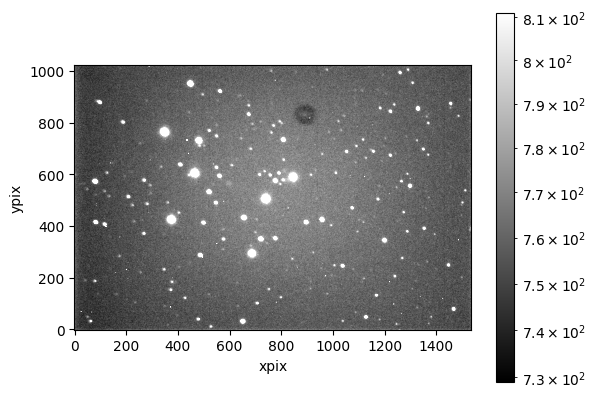

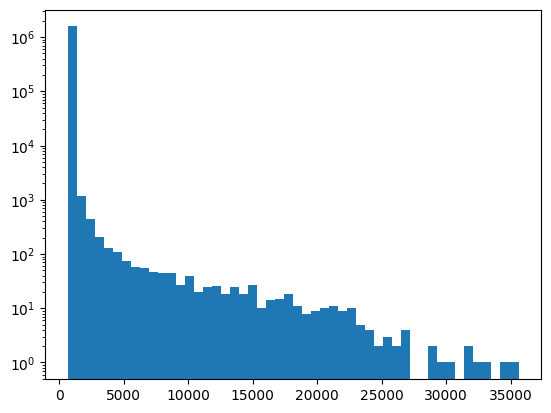

m29_2023-09-20_20-31-52_black_0160.fits


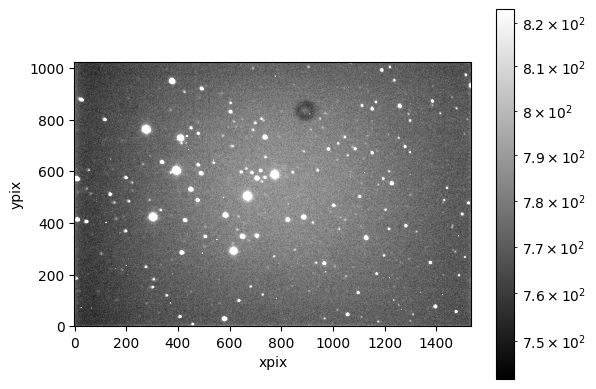

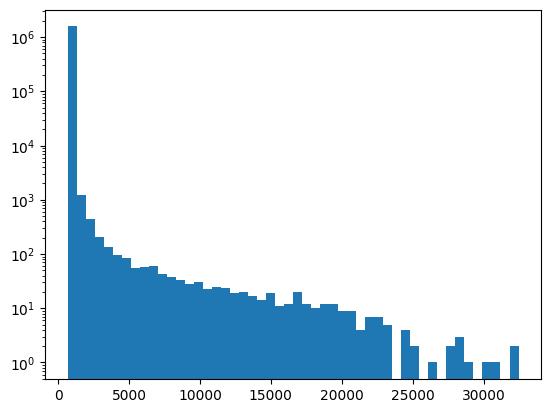

m29_2023-09-20_20-32-26_black_0161.fits


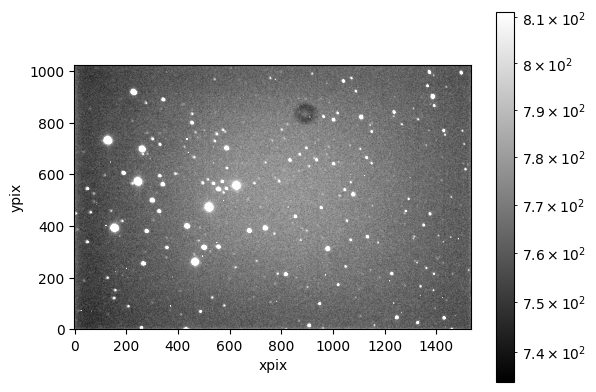

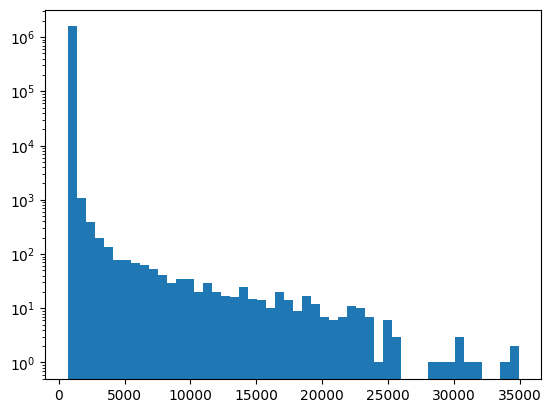

m29_2023-09-20_20-33-35_black_0162.fits


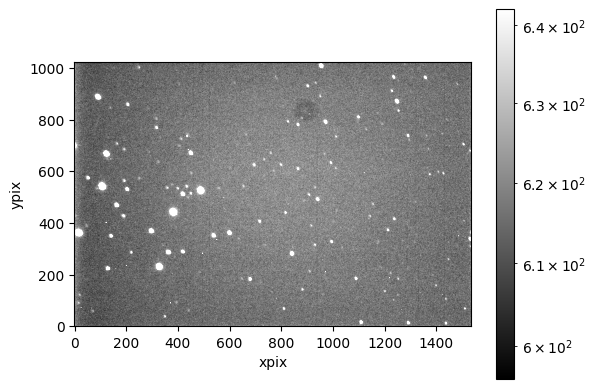

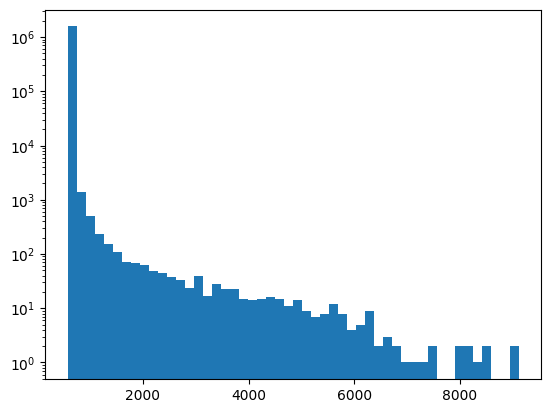

m29_2023-09-20_20-33-50_black_0163.fits


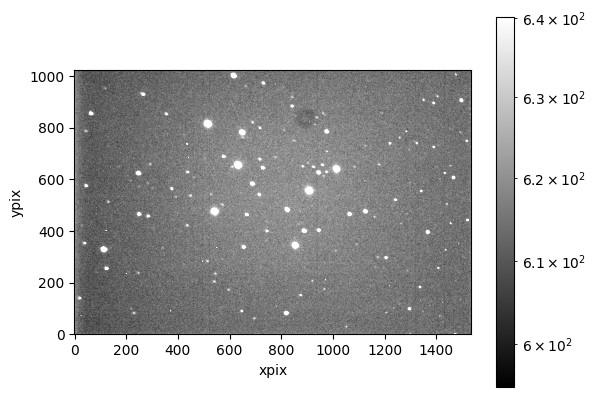

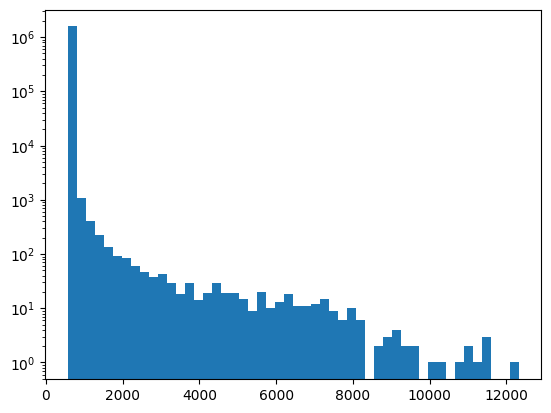

m29_2023-09-20_20-35-00_Green_0164.fits


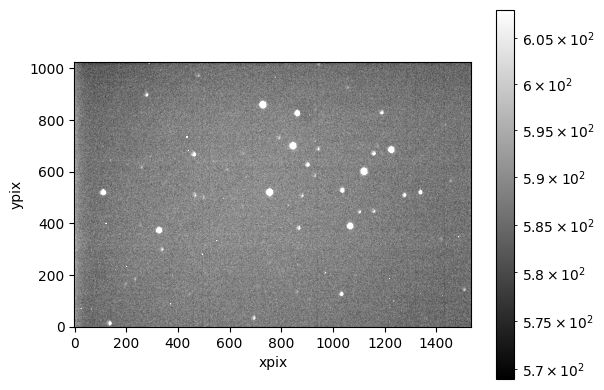

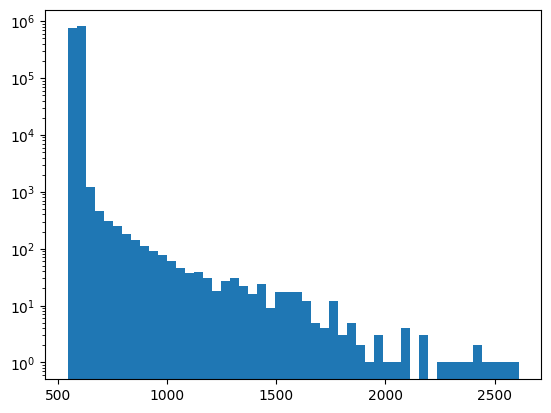

m29_2023-09-20_20-35-24_Green_0165.fits


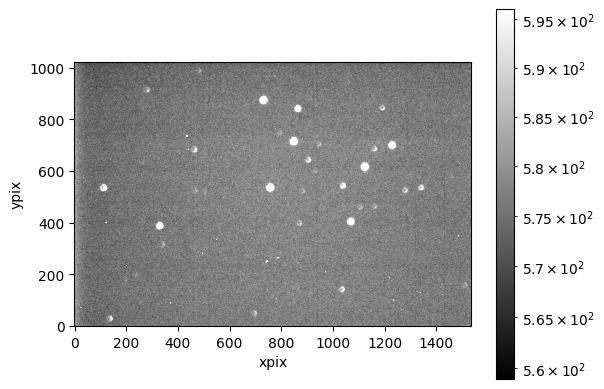

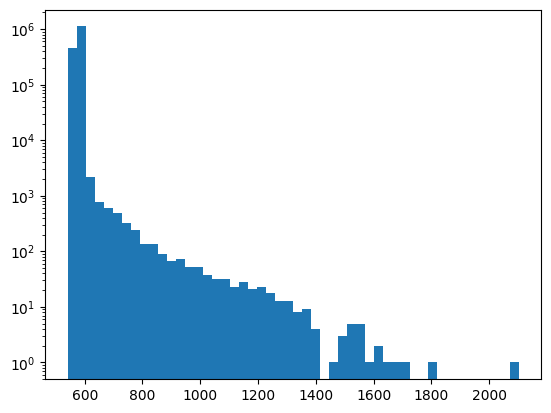

m29_2023-09-20_20-35-41_Green_0166.fits


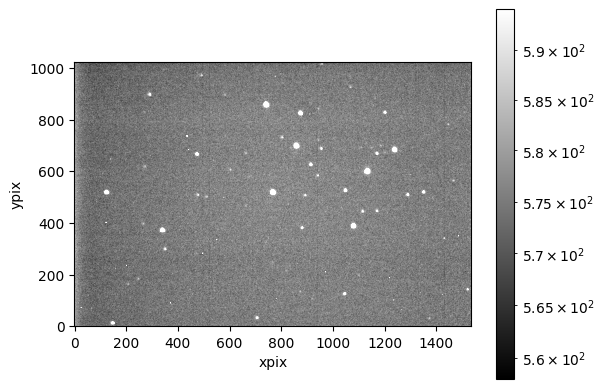

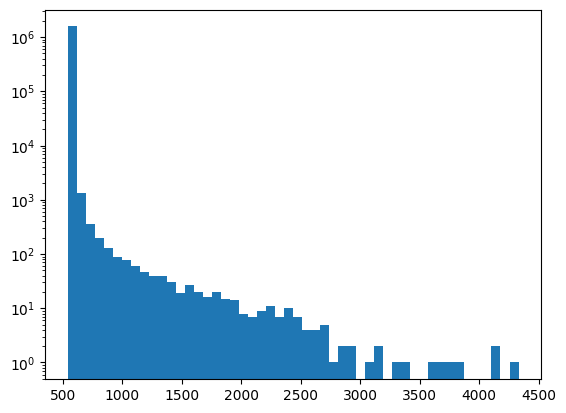

m29_2023-09-20_20-36-04_Green_0167.fits


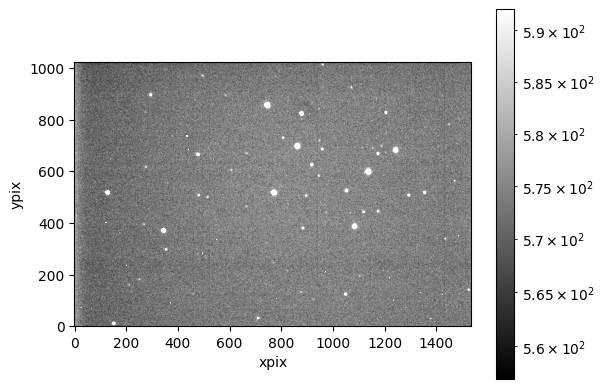

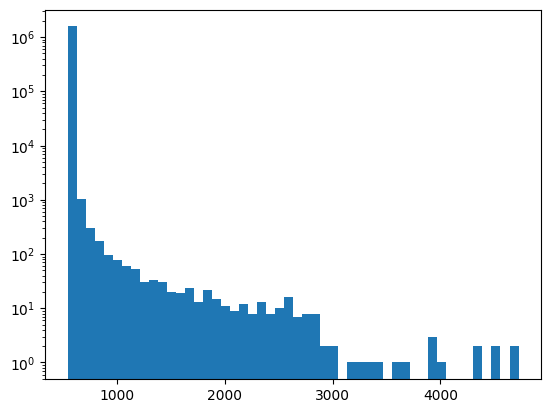

m29_2023-09-20_20-36-44_Green_0168.fits


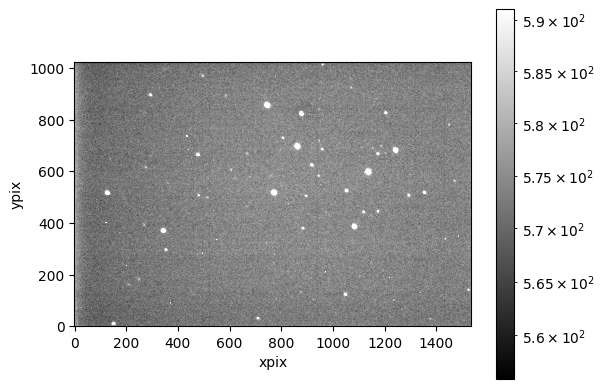

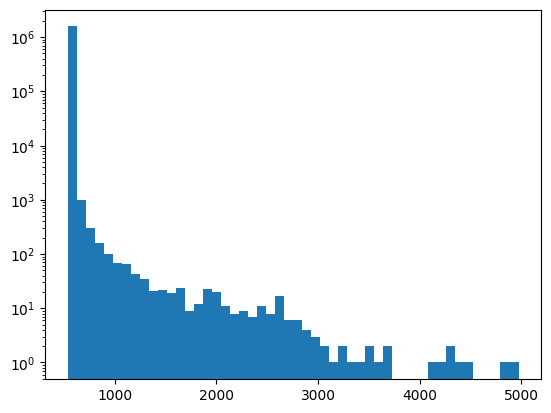

m29_2023-09-20_20-39-06_Green_0169.fits


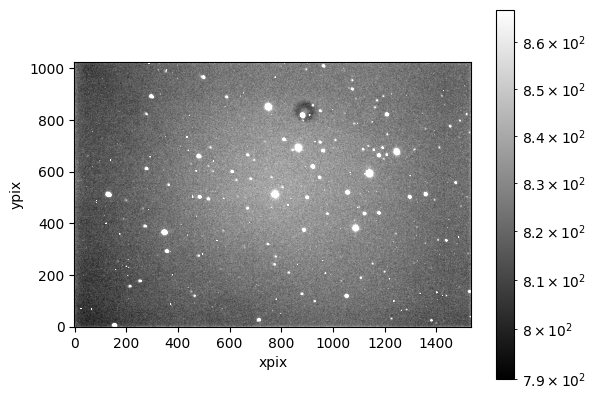

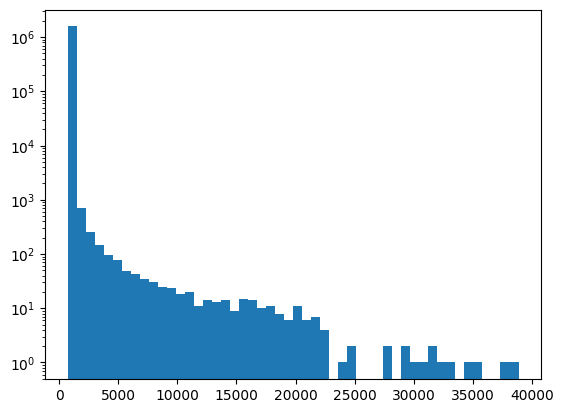

m29_2023-09-20_20-39-54_Green_0170.fits


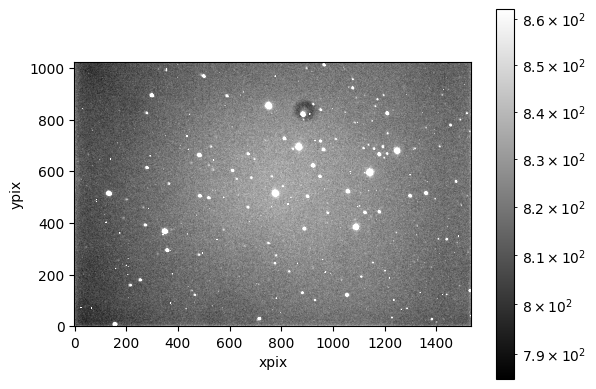

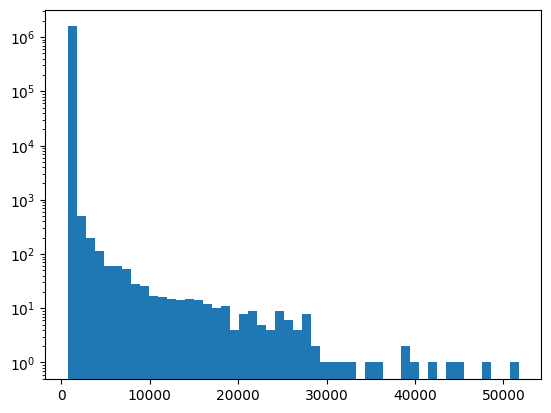

m29_2023-09-20_20-40-41_Green_0171.fits


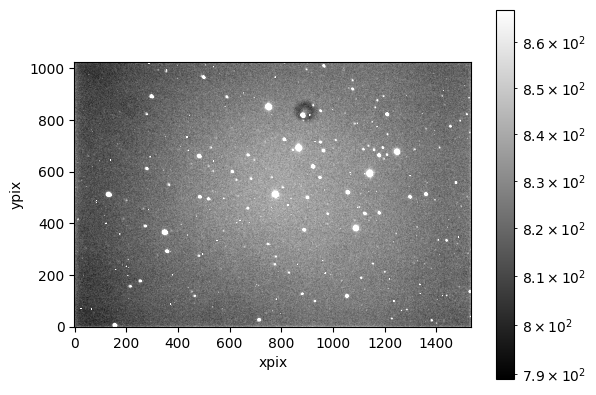

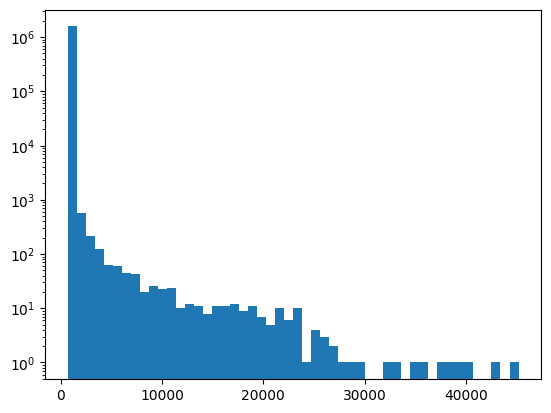

m29_2023-09-20_20-41-29_Green_0172.fits


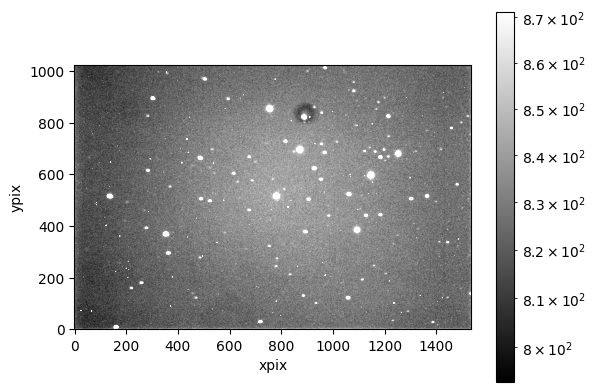

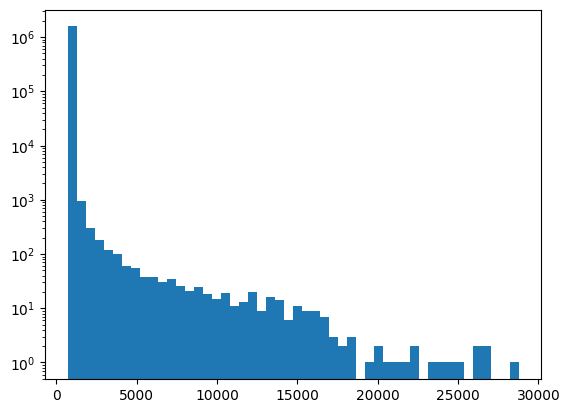

m29_2023-09-20_20-42-17_Green_0173.fits


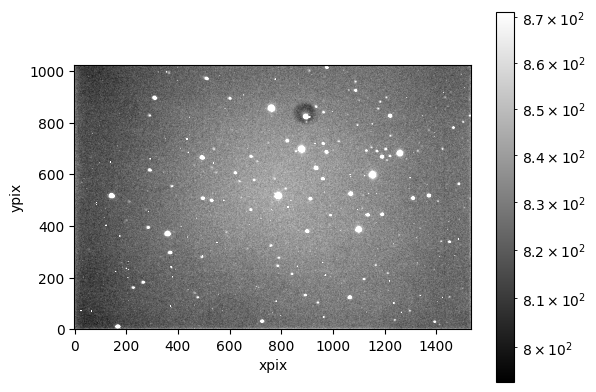

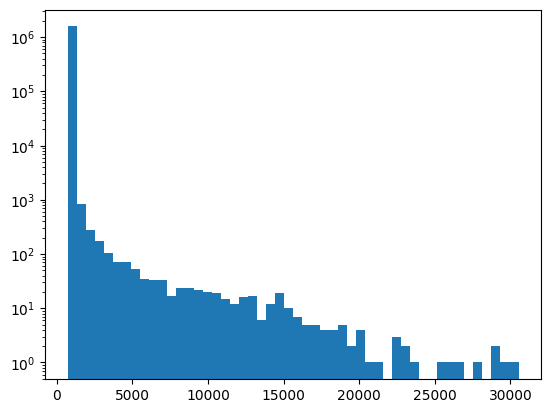

m29_2023-09-20_20-43-04_Green_0174.fits


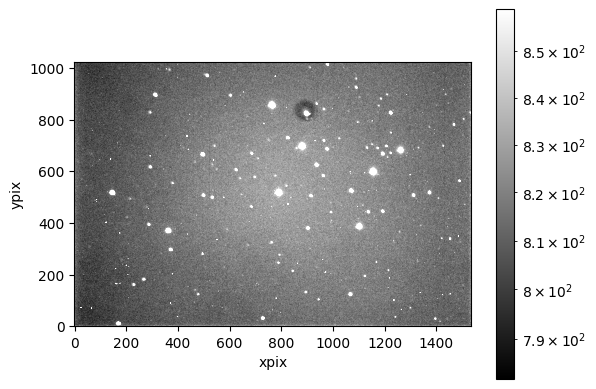

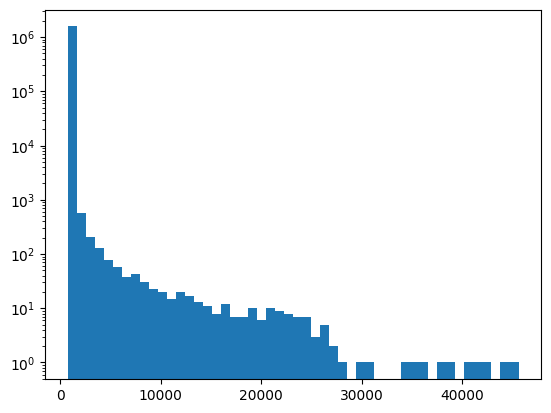

m29_2023-09-20_20-43-52_Green_0175.fits


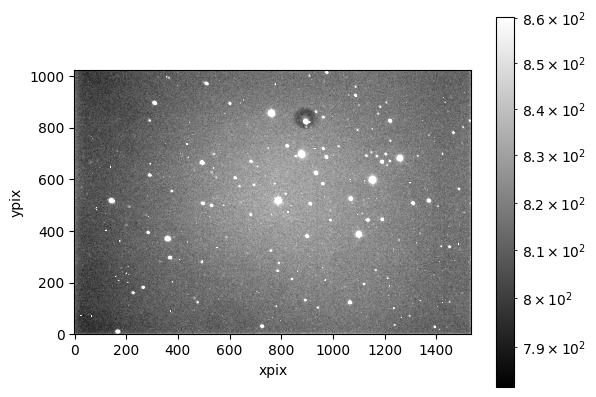

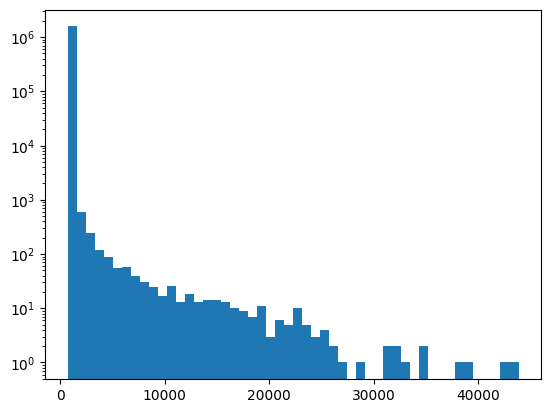

m29_2023-09-20_20-44-40_Green_0176.fits


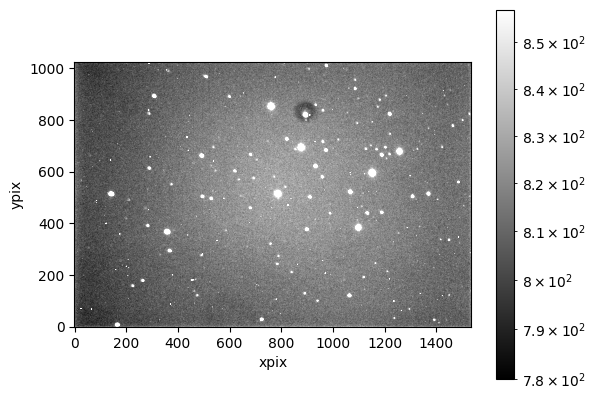

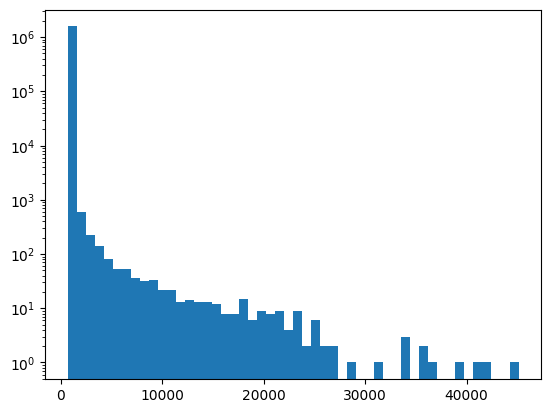

m29_2023-09-20_20-45-27_Green_0177.fits


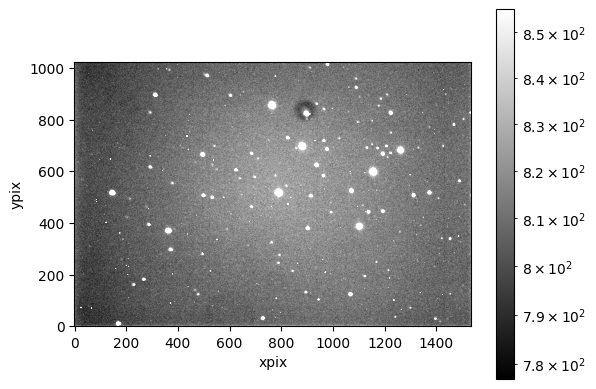

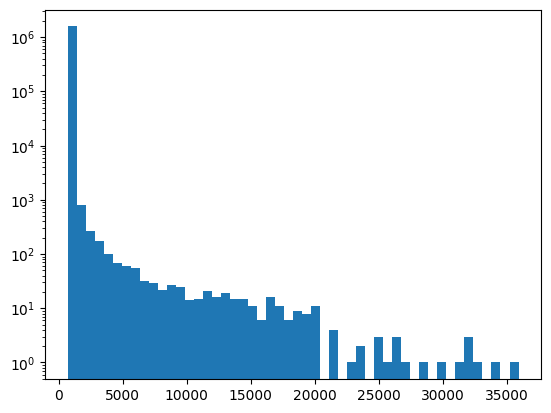

m29_2023-09-20_20-46-15_Green_0178.fits


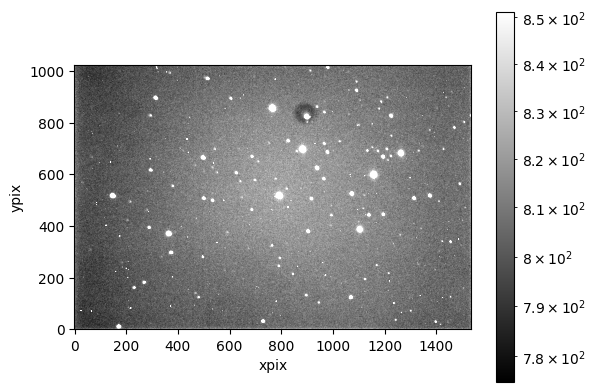

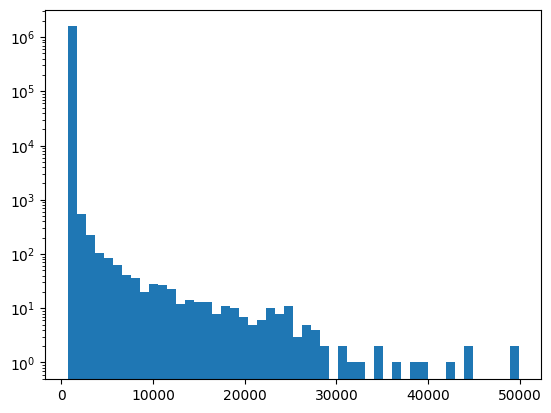

m29_2023-09-20_20-48-10_Blue_0179.fits


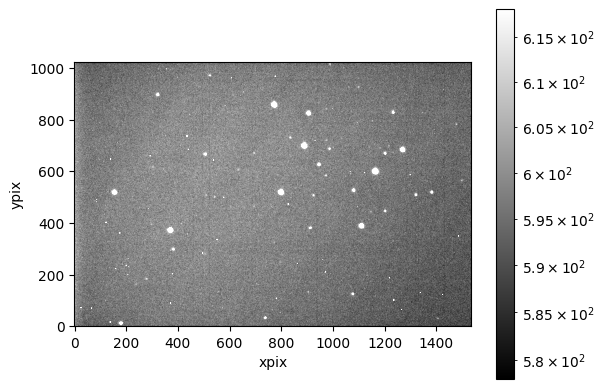

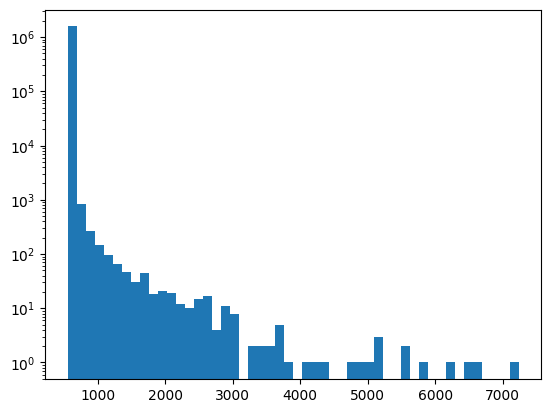

In [26]:
data_path = 'data/20230920/'
i = 0

for file in os.listdir(data_path):

    if 'm29' in file:
        m29 = fits.open(name=data_path+file)
        m29 = m29[0].data
        m29 = m29 + np.asarray(m29/np.median(m29))
        #np.shape(allflat)
        print(file)
        lo,up= np.percentile(m29,1),np.percentile(m29,99)
        plt.figure()
        plt.imshow(m29, cmap='gray', origin='lower', clim=(lo,up), norm='log')
        plt.colorbar()
        plt.xlabel('xpix')
        plt.ylabel('ypix')
        plt.show()
        
        plt.figure()
        plt.hist(m29.flatten(),bins=50, log=True)
        plt.show()
        i+=1
        if 'm29' in file and 'Blue' in file:
            break


Just DAOStarFinder

In [34]:
## Get background
mean, median, std = sigma_clipped_stats(m29,sigma=3.0,maxiters=20)
## Find stars
daofind = DAOStarFinder(fwhm=10.0, #see teacher's notebook, he does a 2d gaussian fit to the brightest stars to get a better estimate of the FWHM
                        threshold=4.0*std)  ##peakmax to exclude saturated stars!!
sources = daofind(m29 - median)
print("     Found %i stars in image " %len(sources))

     Found 57 stars in image 


Text(0, 0.5, 'y (pix)')

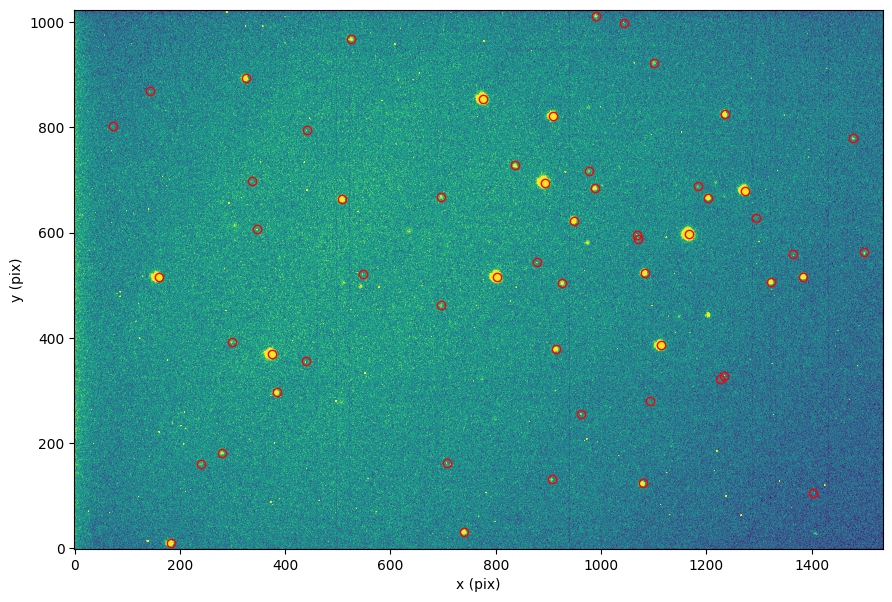

In [35]:
fig = plt.figure(figsize=(12,7))
l1 = np.percentile(m29[np.isfinite(m29)].flatten(), 1)
l2 = np.percentile(m29[np.isfinite(m29)].flatten(), 99)
plt.imshow(m29,clim=(l1,l2),origin='lower')
plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
plt.xlabel("x (pix)")
plt.ylabel("y (pix)")

In [61]:
nbright = 10
brightest = np.argsort(sources['flux'])[::-1][0:nbright]
brsources = sources[brightest]
print(brsources)

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
 32 1167.2620178478676 ... 435.51649747098804  -6.597511527090045
 42  893.0120022874464 ... 205.40617916278165  -5.781533760469774
 23  802.7453906642397 ... 181.65711912382562  -5.648131056220879
 51  776.6046882685006 ... 169.80684854219837  -5.574888004877411
 17 1113.6435039920486 ... 158.61828682460146 -5.5008831372962765
 39 1272.6980036607895 ... 155.42873566257828  -5.478828285615157
 15 375.63911713414814 ...  94.93565196557269  -4.943573343087179
 49  909.2512889418471 ...  54.50788358376723 -4.3411482992384185
 22 159.42261262036166 ...  52.33542970872982  -4.296989485913347
 26 1082.6487623123787 ...  19.96825361226502 -3.2508502097829424


In [62]:
x_init = np.array(brsources['xcentroid'])
y_init = np.array(brsources['ycentroid'])

Iterative PSF Photometry

In [63]:

# PSF is assumed to be a gaussian
psf_model = IntegratedGaussianPRF() #could have some diferrent shape
# use a better model after knowing the fwhm, perhaps perform a 2d gaussian to allow for it not to be symmmetrical
# the psf model (the shape) will be the same for the brightest stars will be the same for the fainter ones

bkgstat = MMMBackground()

localbkg_estimator = LocalBackground(5, 10, bkgstat) 


itPSF = IterativePSFPhotometry(psf_model,
                               fit_shape=(5,5), #play with this, this may be small
                               localbkg_estimator=localbkg_estimator, #could also be done manually see the teacher's collab
                               finder=daofind, 
                               aperture_radius = 4 #play with this as well
                               )

In [64]:


init_params = QTable()
init_params['x'] =x_init
init_params['y'] =y_init
phot = itPSF(m29, init_params=init_params)

In [65]:
phot

<QTable length=78>
  id  group_id iter_detected ...         qfit                 cfit         flags
int64  int64       int64     ...       float64              float64        int64
----- -------- ------------- ... ------------------- --------------------- -----
    1        1             1 ...  0.7198449417837315 -0.030079126145278013     0
    2        2             1 ...   0.721377976421041  -0.04485449894067422     0
    3        3             1 ...  0.7311223674532238  -0.05090519550875061     0
    4        4             1 ...  0.7136105052142957  -0.05287217472730867     0
    5        5             1 ...  0.6332617259052773 -0.041288653083559126     0
    6        6             1 ...  0.6465908410091955  -0.05045850949999559     0
    7        7             1 ...   0.803406208343714 -0.056637770544375965     0
    8        8             1 ...   0.817966396804973 -0.031153145656265823     0
    9        9             1 ...  0.8770355465711231   -0.0345081351669673     0
   10       10             1 ...   0.556606478761447  -0.03467440250940129     0
  ...      ...           ... ...                 ...                   ...   ...
   69       69             2 ...   1.032586405654374  -0.06078579461521508     0
   70       70             2 ...  1.9452319373134221  -0.03246940308176337     0
   71       71             3 ... -1.1839620209246566  -0.06653223854248128    12
   72       72             3 ... -1.2051479147039204   -0.0709072385542009    12
   73       73             3 ... -1.1740998882114815  -0.06657730250019567     4
   74       74             3 ...  1.8920788353173499  -0.04258618357454131     0
   75       75             3 ... -1.8144207833404027 -0.060759432064143803     4
   76       76             3 ...  0.7543811105483459   0.04174200644890371     0
   77       77             3 ...  -1.211421230149962  -0.06965333385702527     4
   78       78             3 ... -1.2267965800281493   -0.0549362087059089     4